# Importing libraries



In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd
from torch.autograd import Variable
from collections import deque
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Plotting functions

In [2]:
def plot_mean_variance_plot(rewards1,rewards2 = None,env_id=None,Type=None):

  # change rewards2 if you want comparitive plot between rewards1 and rewards2.
  # Otherwise it will just plot mean and variance plot for rewards1.
  rewards1 = np.array(rewards1)
  mean_rewards1 = rewards1.mean(axis=0)
  std_rewards1 = rewards1.std(axis=0)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  x = np.arange(1, len(mean_rewards1)+1)
  if rewards2:
    rewards2 = np.array(rewards2)
    mean_rewards2 = rewards2.mean(axis=0)
    std_rewards2 = rewards2.std(axis=0)
    ax.plot(x, mean_rewards1, '-',label = "Type_1 update (mean of advantage)",color='red')
    ax.fill_between(x, mean_rewards1 - std_rewards1, mean_rewards1 + std_rewards1, color='red', alpha=0.2)
    ax.plot(x, mean_rewards2, '-',label = "Type_2 update (max of advantage)",color='blue')
    ax.fill_between(x, mean_rewards2 - std_rewards2, mean_rewards2 + std_rewards2, color='blue', alpha=0.2)
    plt.ylabel('Rewards')
    plt.xlabel('Episode #')
    plt.title(f'Comparitive performance of Dueling DQN in {env_id} for 2 update types averaged over 5 seeds')
    plt.legend()
    plt.show()
  else:
    ax.plot(x, mean_rewards1, '-', color='red')
    ax.fill_between(x, mean_rewards1 - std_rewards1, mean_rewards1+ std_rewards1, color='blue', alpha=0.2)
    plt.ylabel('Rewards')
    plt.xlabel('Episode #')
    plt.title(f'Dueling DQN in {env_id} with {Type} update averaged over 5 seeds')
    plt.show()

# Replay memory

In [3]:
# Replay memory to record experience and sample state,action,reward,next_state tuples.
class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

# Main network

In [4]:
# Q value function network.
class qnet(nn.Module):
    def __init__(self,in_channels,hidden_channels,num_actions,Type):
        '''
        in_channels => dimension of input state space.
        hidden_channels => hyperparameter , can be adjusted from outside
        num_actions => output dim, action space dimension.
        '''
        super(qnet, self).__init__()
        self.num_actions = num_actions
        # fc1 layer to extract state features.
        self.fc1 = nn.Linear(in_channels,hidden_channels)

        # value network to approximate the value function.
        self.Value_network = nn.Sequential(nn.Linear(hidden_channels,hidden_channels*4),
                               nn.ReLU(),
                               nn.Linear(hidden_channels*4,1))

        # advantage function network to approximate the advantage function
        self.Advantage_network = nn.Sequential(nn.Linear(hidden_channels,hidden_channels*4),
                               nn.ReLU(),
                               nn.Linear(hidden_channels*4,num_actions))

        # type of update we want to do.
        self.Type = Type


    def forward(self,state):
      '''
      Type 1 update => we use mean operator on advantage function
                       in the Q-value update equation.
      Type 2 update => we use max operator on advantage function
                       in the Q-value update equation.

      '''

      features = F.relu(self.fc1(state))

      V = self.Value_network(features)
      A = self.Advantage_network(features)

      if self.Type == "Type_1":
        Qvalues = V + A-torch.mean(A, dim=1, keepdim=True)
      else:
        Qvalues = V + A-torch.max(A, dim=1, keepdim=True)[0]
      return Qvalues

    def select_action(self,state):
      with torch.no_grad():
        q = self.forward(state)
        action_index = torch.argmax(q,dim=1)
      return action_index.item()

# Dueling DQN experiment code

In [ ]:
import sys
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
max_episodes = 300
max_steps = 200


def run_experiment(env_id,Type,seed,batch_size,learning_rate,epsilon,gamma,hidden_channels,print_flag,plot_flag):
  learning_steps = 0
  target_update = 4
  env = gym.make(env_id)

  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  env.seed(seed)
  n_state = env.observation_space.shape[0]
  n_action = env.action_space.n
  # q network
  model_network = qnet(n_state,hidden_channels,n_action,Type).to(device)
  # target network
  target_network =  qnet(n_state,hidden_channels,n_action,Type).to(device)
  target_network.load_state_dict(model_network.state_dict())
  optimizer = torch.optim.Adam(model_network.parameters(), lr=3e-4)
  memory = Memory(500000)
  ep_rewards = []
  avg_rewards = []
  episode_reward = 0
  for episode in range(max_episodes):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps):

      # define E-greedy policy for selecting actions.
      if random.random()<epsilon:
        action = random.randint(0,n_action-1)
      else:
        t_state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = model_network.select_action(t_state)

      next_state,reward,done,_ = env.step(action)
      episode_reward+=reward
      memory.push(state, action, reward, next_state, done)
      if len(memory)>128:

        # after earning enough experience, learning begins.
        learning_steps +=1

        # we update the taget network after target_update number of steps.
        if learning_steps%target_update == 0:
          target_network.load_state_dict(model_network.state_dict())

        states, actions, rewards, next_states, dones = memory.sample(batch_size)
        batch_states = torch.FloatTensor(states).to(device)
        batch_actions = torch.FloatTensor(actions).unsqueeze(1).to(device)
        batch_rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        batch_next_states = torch.FloatTensor(next_states).to(device)
        batch_dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # calculating the loss and doing backpropogation
        with torch.no_grad():
          q_pred_next = model_network.forward(batch_next_states)
          q_target_next = target_network.forward(batch_next_states)
          max_action = torch.argmax(q_pred_next,dim=1,keepdim = True)
          q_target = batch_rewards + (1-batch_dones)*gamma*q_target_next.gather(1,max_action.long())

        q_pred =  model_network.forward(batch_states).gather(1,batch_actions.long())
        loss = F.mse_loss(q_pred,q_target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      if done:
        break

      state = next_state

    ep_rewards.append(episode_reward)
    avg_rewards.append(np.mean(ep_rewards[-10:]))
    if print_flag and episode%10 == 0:
      sys.stdout.write("episode: {}, reward: {}, average_reward: {}\n".format(episode, np.round(episode_reward, decimals=2),np.mean(ep_rewards[-10:])))

  sys.stdout.write("Experiment completed! Rewards recorded!\n")
  if plot_flag:
    plt.plot(ep_rewards)
    plt.plot(avg_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()
  return ep_rewards,avg_rewards

# Acrobot code test

In [ ]:
env_id = 'Acrobot-v1'
# define hyperparameters here.
batch_size = 16
learning_rate = 3e-4
epsilon = 0.1
gamma = 0.99
hidden_channels = 64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

episode: 0, reward: -200.0, average_reward: -200.0
episode: 10, reward: -148.0, average_reward: -194.8
episode: 20, reward: -174.0, average_reward: -153.1
episode: 30, reward: -200.0, average_reward: -188.5
episode: 40, reward: -113.0, average_reward: -138.9
episode: 50, reward: -88.0, average_reward: -143.8
episode: 60, reward: -120.0, average_reward: -151.1
episode: 70, reward: -84.0, average_reward: -124.5
episode: 80, reward: -140.0, average_reward: -117.3
episode: 90, reward: -81.0, average_reward: -108.0
episode: 100, reward: -88.0, average_reward: -115.5
episode: 110, reward: -77.0, average_reward: -113.3
episode: 120, reward: -94.0, average_reward: -96.4
episode: 130, reward: -145.0, average_reward: -118.4
episode: 140, reward: -88.0, average_reward: -88.5
episode: 150, reward: -151.0, average_reward: -109.6
episode: 160, reward: -97.0, average_reward: -104.4
episode: 170, reward: -115.0, average_reward: -98.9
episode: 180, reward: -111.0, average_reward: -101.6
episode: 190, r

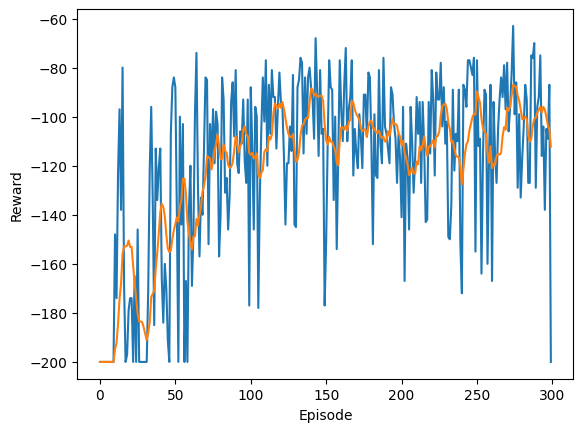

In [ ]:
acrobat_rewards_type1,acrobat_avg_rewards_type1 = run_experiment(env_id,"Type_1",42,batch_size,learning_rate,epsilon,gamma,hidden_channels,print_flag=True,plot_flag = True)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-47-9e90334b2c5d>:49: UserWarning: Using a target size (torch.Size([16, 16, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead

episode: 0, reward: -200.0, average_reward: -200.0
episode: 10, reward: -109.0, average_reward: -172.8
episode: 20, reward: -82.0, average_reward: -108.6
episode: 30, reward: -118.0, average_reward: -119.1
episode: 40, reward: -124.0, average_reward: -155.0
episode: 50, reward: -101.0, average_reward: -127.9
episode: 60, reward: -92.0, average_reward: -104.5
episode: 70, reward: -97.0, average_reward: -109.7
episode: 80, reward: -115.0, average_reward: -109.6
episode: 90, reward: -96.0, average_reward: -113.3
episode: 100, reward: -91.0, average_reward: -113.7
episode: 110, reward: -200.0, average_reward: -112.3
episode: 120, reward: -70.0, average_reward: -101.3
episode: 130, reward: -85.0, average_reward: -107.6
episode: 140, reward: -115.0, average_reward: -100.1
episode: 150, reward: -85.0, average_reward: -92.9
episode: 160, reward: -105.0, average_reward: -90.3
episode: 170, reward: -111.0, average_reward: -98.1
episode: 180, reward: -116.0, average_reward: -105.2
episode: 190, r

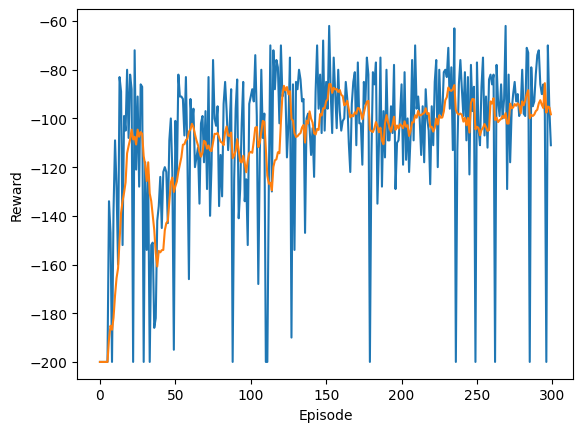

In [ ]:
acrobat_rewards_type2,acrobat_avg_rewards_type2 = run_experiment(env_id,"Type_2",42,batch_size,learning_rate,epsilon,gamma,hidden_channels,print_flag=True,plot_flag = True)

So the rewards are increasing properly for both update types.

# CartPole code test

In [ ]:
env_id = 'CartPole-v1'
batch_size = 16
learning_rate = 3e-4
epsilon = 0.1
gamma = 0.99
hidden_channels = 64

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-47-9e90334b2c5d>:49: UserWarning: Using a target size (torch.Size([16, 16, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead

episode: 0, reward: 10.0, average_reward: 10.0
episode: 10, reward: 9.0, average_reward: 10.1
episode: 20, reward: 8.0, average_reward: 10.1
episode: 30, reward: 11.0, average_reward: 9.9
episode: 40, reward: 11.0, average_reward: 10.3
episode: 50, reward: 12.0, average_reward: 10.7
episode: 60, reward: 10.0, average_reward: 11.6
episode: 70, reward: 15.0, average_reward: 12.6
episode: 80, reward: 11.0, average_reward: 15.5
episode: 90, reward: 37.0, average_reward: 27.1
episode: 100, reward: 15.0, average_reward: 19.7
episode: 110, reward: 17.0, average_reward: 16.9
episode: 120, reward: 89.0, average_reward: 28.5
episode: 130, reward: 95.0, average_reward: 51.6
episode: 140, reward: 123.0, average_reward: 82.3
episode: 150, reward: 130.0, average_reward: 148.3
episode: 160, reward: 124.0, average_reward: 139.1
episode: 170, reward: 156.0, average_reward: 165.9
episode: 180, reward: 200.0, average_reward: 175.8
episode: 190, reward: 179.0, average_reward: 172.6
episode: 200, reward: 2

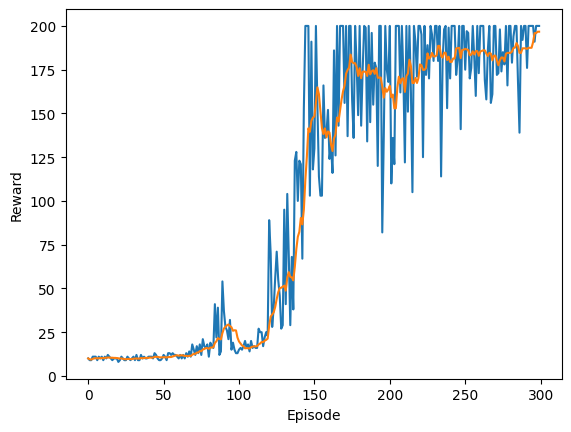

In [ ]:
cartpole_rewards_type1,cartpole_avg_rewards_type1 = run_experiment(env_id,"Type_1",42,batch_size,learning_rate,epsilon,gamma,hidden_channels,print_flag=True,plot_flag = True)

episode: 0, reward: 9.0, average_reward: 9.0
episode: 10, reward: 10.0, average_reward: 9.4


<ipython-input-47-9e90334b2c5d>:49: UserWarning: Using a target size (torch.Size([16, 16, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_pred,q_target)


episode: 20, reward: 9.0, average_reward: 9.6
episode: 30, reward: 11.0, average_reward: 10.0
episode: 40, reward: 10.0, average_reward: 9.9
episode: 50, reward: 11.0, average_reward: 9.6
episode: 60, reward: 10.0, average_reward: 12.2
episode: 70, reward: 22.0, average_reward: 24.5
episode: 80, reward: 45.0, average_reward: 31.5
episode: 90, reward: 169.0, average_reward: 142.7
episode: 100, reward: 200.0, average_reward: 148.5
episode: 110, reward: 200.0, average_reward: 180.3
episode: 120, reward: 200.0, average_reward: 195.9
episode: 130, reward: 200.0, average_reward: 191.1
episode: 140, reward: 200.0, average_reward: 196.1
episode: 150, reward: 200.0, average_reward: 198.7
episode: 160, reward: 183.0, average_reward: 189.1
episode: 170, reward: 200.0, average_reward: 200.0
episode: 180, reward: 151.0, average_reward: 195.1
episode: 190, reward: 200.0, average_reward: 200.0
episode: 200, reward: 200.0, average_reward: 200.0
episode: 210, reward: 200.0, average_reward: 199.0
episod

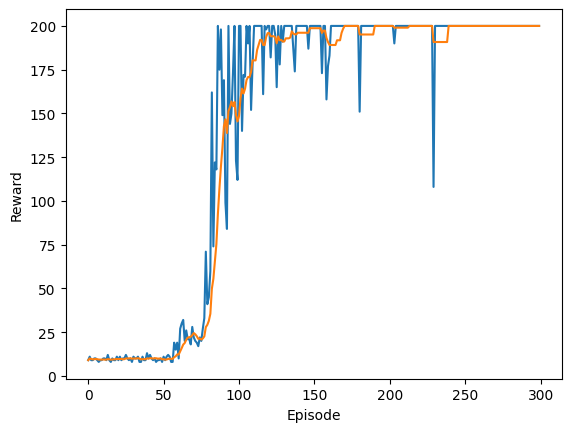

In [ ]:
cartpole_rewards_type2,cartpole_avg_rewards_type2 = run_experiment(env_id,"Type_2",42,batch_size,learning_rate,epsilon,gamma,hidden_channels,print_flag=True,plot_flag = True)

So the rewards are increasing properly for both update types.

## Experiments

# AcroBot


In [ ]:
env_id = 'Acrobot-v1'
batch_size = 16
learning_rate = 3e-4
epsilon = 0.1
gamma = 0.99
hidden_channels = 64

In [ ]:
#running 5 experiments.
np.random.seed(42)
seeds = np.random.randint(1000, size=5)
all_acrobot_type1_rewards = []
all_acrobot_type1_avg_rewards = []
exp = 1
for seed in seeds:
  print(f"Experiment {exp} => Training started\n")
  rewards,avg_rewards = run_experiment(env_id,"Type_1",int(seed),batch_size,learning_rate,epsilon,gamma,hidden_channels,print_flag=False,plot_flag = False)
  all_acrobot_type1_rewards.append(rewards)
  all_acrobot_type1_avg_rewards.append(avg_rewards)
  exp+=1

Experiment 1 => Training started

Experiment completed! Rewards recorded!
Experiment 2 => Training started

Experiment completed! Rewards recorded!
Experiment 3 => Training started

Experiment completed! Rewards recorded!
Experiment 4 => Training started

Experiment completed! Rewards recorded!
Experiment 5 => Training started

Experiment completed! Rewards recorded!


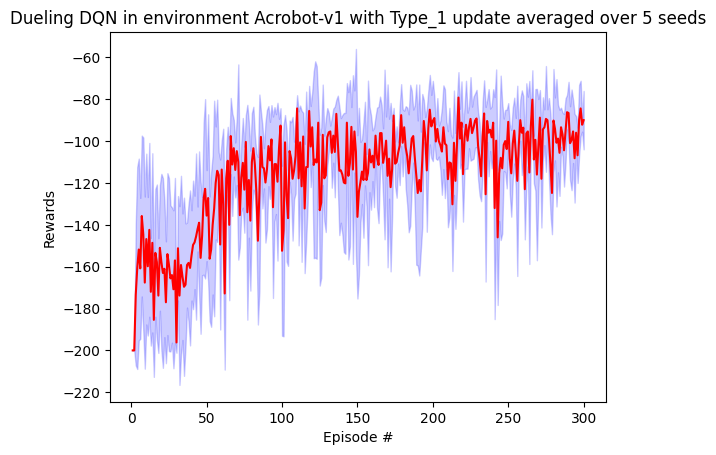

In [ ]:
# plot of mean and variance for just acrobot rewards
plot_mean_variance_plot(all_acrobot_type1_rewards,env_id = env_id,Type = "Type_1")

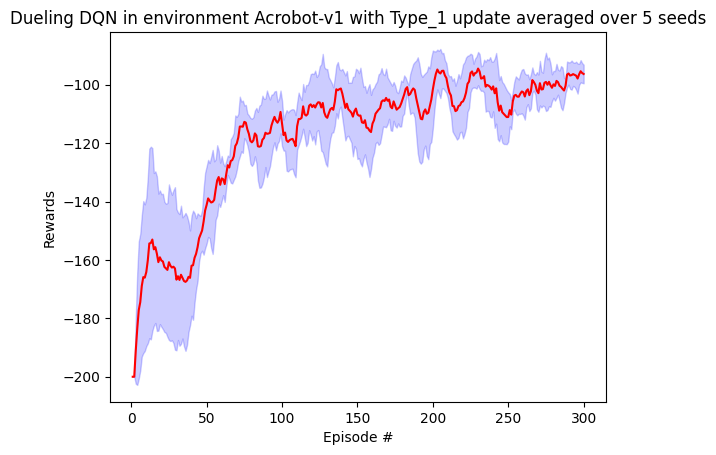

In [ ]:
# plot of mean and variance for average acrobot rewards
plot_mean_variance_plot(all_acrobot_type1_avg_rewards,env_id = env_id,Type = "Type_1")

In [ ]:
np.random.seed(42)
seeds = np.random.randint(1000, size=5)
all_acrobot_type2_rewards = []
all_acrobot_type2_avg_rewards = []
exp = 1
for seed in seeds:
  print(f"Experiment {exp} => Training started\n")
  print("...................................\n")
  rewards,avg_rewards = run_experiment(env_id,"Type_2",int(seed),batch_size,learning_rate,epsilon,gamma,hidden_channels,print_flag=False,plot_flag = False)
  all_acrobot_type2_rewards.append(rewards)
  all_acrobot_type2_avg_rewards.append(avg_rewards)
  exp+=1

Experiment 1 => Training started

...................................

Experiment completed! Rewards recorded!
Experiment 2 => Training started

...................................

Experiment completed! Rewards recorded!
Experiment 3 => Training started

...................................

Experiment completed! Rewards recorded!
Experiment 4 => Training started

...................................

Experiment completed! Rewards recorded!
Experiment 5 => Training started

...................................

Experiment completed! Rewards recorded!


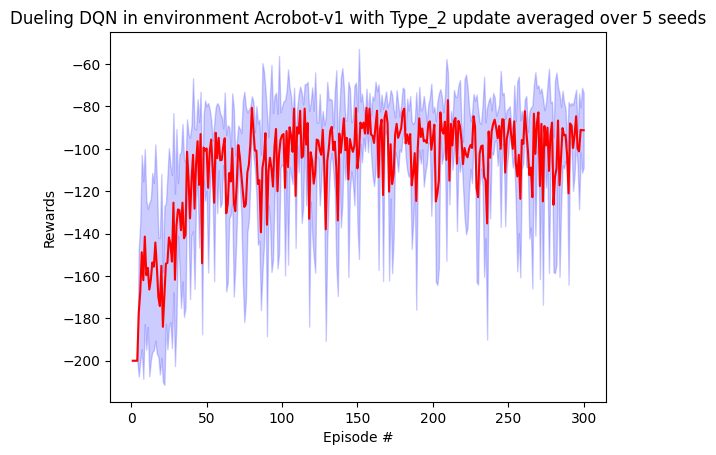

In [ ]:
plot_mean_variance_plot(all_acrobot_type2_rewards,env_id  = env_id,Type = "Type_2")

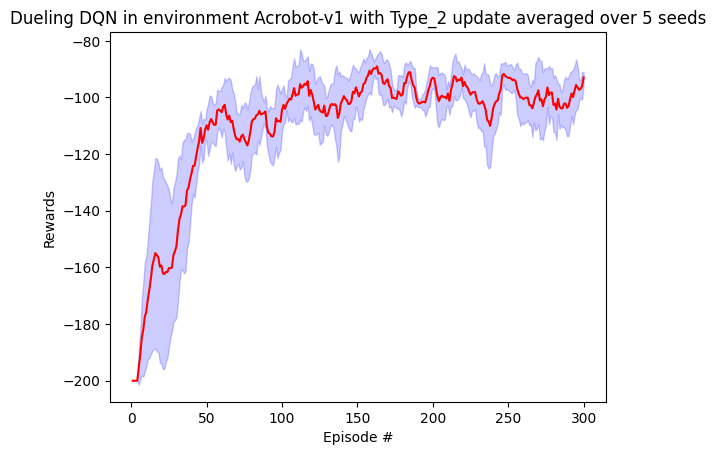

In [ ]:
plot_mean_variance_plot(all_acrobot_type2_avg_rewards,env_id  = env_id,Type = "Type_2")

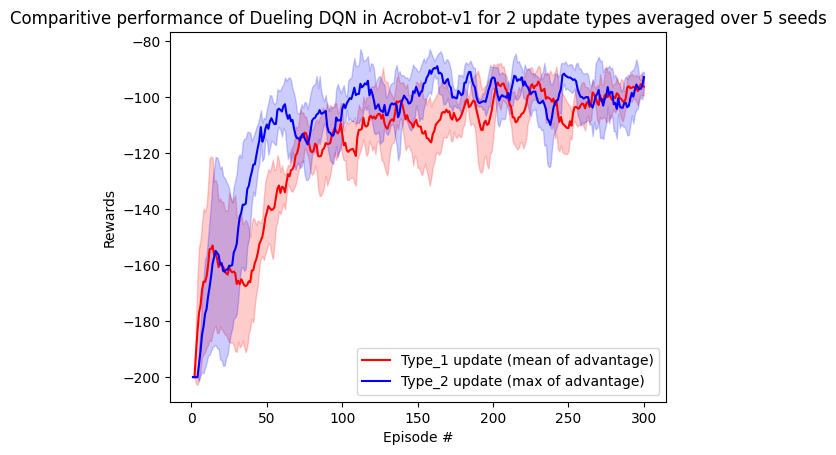

In [ ]:
plot_mean_variance_plot(all_acrobot_type1_avg_rewards,all_acrobot_type2_avg_rewards,env_id = env_id)

# CartPole


In [ ]:
env_id = 'CartPole-v1'
batch_size = 16
learning_rate = 3e-4
epsilon = 0.1
gamma = 0.99
hidden_channels = 64

In [ ]:
np.random.seed(42)
seeds = np.random.randint(1000, size=5)
all_cartpole_type1_rewards = []
all_cartpole_type1_avg_rewards = []
exp = 1
for seed in seeds:
  print(f"Experiment {exp} => Training started\n")
  rewards,avg_rewards = run_experiment(env_id,"Type_1",int(seed),batch_size,learning_rate,epsilon,gamma,hidden_channels,print_flag=False,plot_flag = False)
  all_cartpole_type1_rewards.append(rewards)
  all_cartpole_type1_avg_rewards.append(avg_rewards)
  exp+=1

Experiment 1 => Training started

Experiment completed! Rewards recorded!
Experiment 2 => Training started

Experiment completed! Rewards recorded!
Experiment 3 => Training started

Experiment completed! Rewards recorded!
Experiment 4 => Training started

Experiment completed! Rewards recorded!
Experiment 5 => Training started

Experiment completed! Rewards recorded!


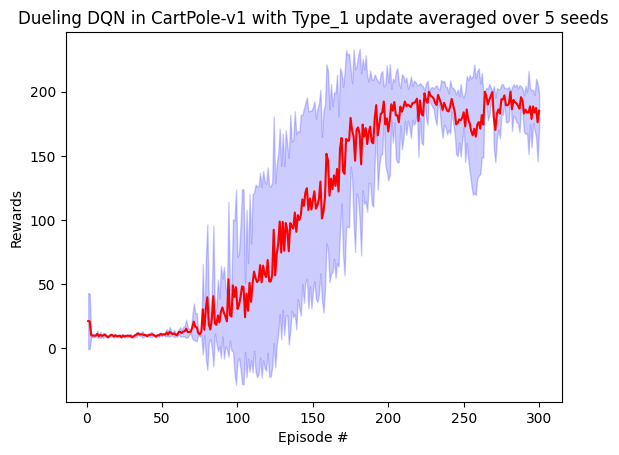

In [ ]:
plot_mean_variance_plot(all_cartpole_type1_rewards,env_id = env_id,Type = "Type_1")

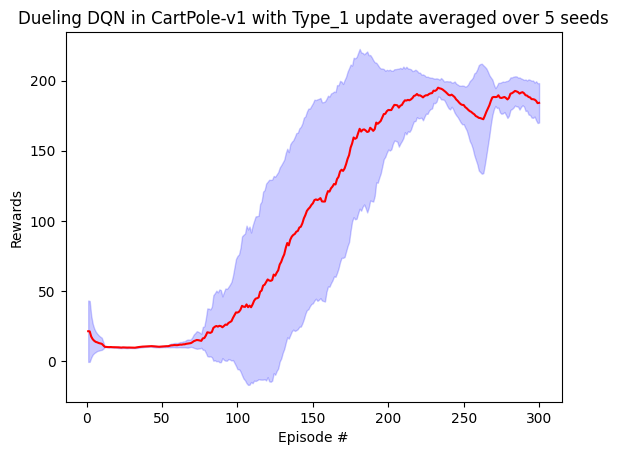

In [ ]:
plot_mean_variance_plot(all_cartpole_type1_avg_rewards,env_id = env_id,Type = "Type_1")

In [ ]:
np.random.seed(42)
seeds = np.random.randint(1000, size=5)
all_cartpole_type2_rewards = []
all_cartpole_type2_avg_rewards = []
exp = 1
for seed in seeds:
  print(f"Experiment {exp} => Training started\n")
  rewards,avg_rewards = run_experiment(env_id,"Type_2",int(seed),batch_size,learning_rate,epsilon,gamma,hidden_channels,print_flag=False,plot_flag = False)
  all_cartpole_type2_rewards.append(rewards)
  all_cartpole_type2_avg_rewards.append(avg_rewards)
  exp+=1

Experiment 1 => Training started

Experiment completed! Rewards recorded!
Experiment 2 => Training started

Experiment completed! Rewards recorded!
Experiment 3 => Training started

Experiment completed! Rewards recorded!
Experiment 4 => Training started

Experiment completed! Rewards recorded!
Experiment 5 => Training started

Experiment completed! Rewards recorded!


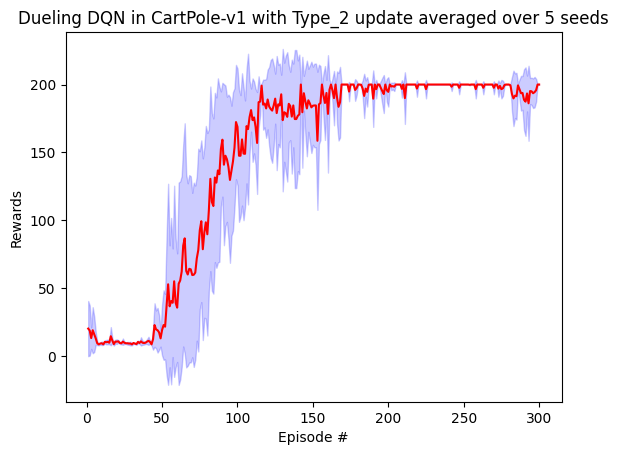

In [ ]:
plot_mean_variance_plot(all_cartpole_type2_rewards,env_id = env_id,Type = "Type_2")

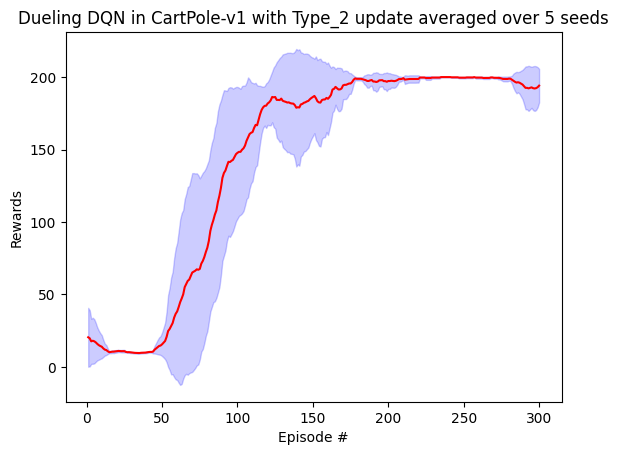

In [ ]:
plot_mean_variance_plot(all_cartpole_type2_avg_rewards,env_id = env_id,Type = "Type_2")

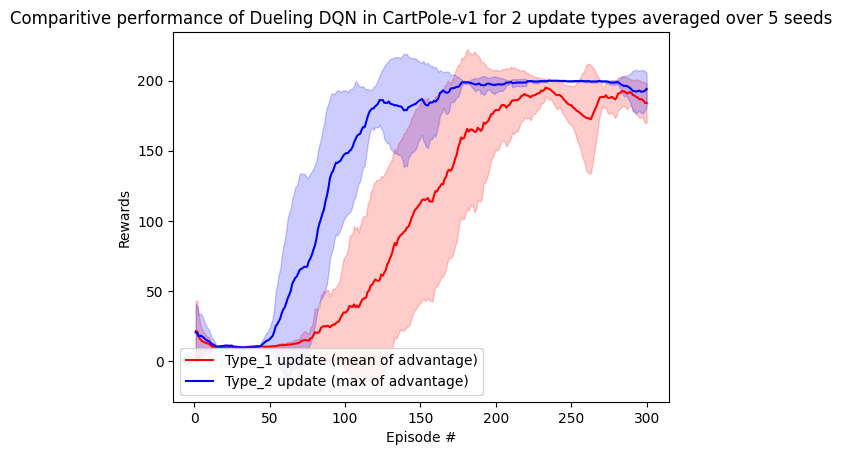

In [ ]:
plot_mean_variance_plot(all_cartpole_type1_avg_rewards,all_cartpole_type2_avg_rewards,env_id = env_id)